In [1]:
#
#
# Use this notebook to build and visualize the impulse analysis dataset. 
#

from dynamic_utils import interval_to_flat_array, parse_time_string_with_colon_offset
from usefulmethods import dynamic2dashboard, fetch_sensor_db_data, logFFT, logFFT2Dmatrix, Welch_matrix_methods, quickFFTobjs, parse_time_string_with_colon_offset, mkDataTimeFromStr,dtObj2str
from impulse_utils import makeData, fracScoreDetector, butter_bandpass, butter_bandpass_filter, butter_lowpass_filter, butter_lowpass, mkFFTstuff, makePerfGunDataset, makeActiveFracsDataset
import os, sys, datetime, subprocess, time, db, statistics, ipywidgets
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.fft as fft
import scipy.fftpack as sfp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
import datetime as dt
from numpy.fft import fft, fftfreq, ifft
from openpyxl import *
from IPython.display import display
import pylab
from math import nan
from matplotlib import cm

%matplotlib inline

plt.rcParams.update({'figure.max_open_warning': 0})
base_folder = '/notebooks/'
TITLE = 'Impulse Investigations: '

# Set Working Directory

base_path = f'/home/ubuntu/legend-analytics/' + base_folder
os.chdir(base_path)
if base_path not in sys.path:
    sys.path.append(base_path)
os.chdir(base_path)
cwd = os.getcwd()

LEGEND_LIVE_DIR = '/home/ubuntu/legend-live'
DATA_RELATIVE_DIR = '../legend-analytics/' #relative to legend-live-repo


In [2]:
# load .xlsx file of events, sensor ids, start and stop strings, perf lengths...

RECORDS = 'Impulse_Investigations_DataSet.xlsx'

df = pd.read_excel(RECORDS)
df

EVENT_CLASS                 START_TIME  \
0        PERF_GUN_FIRING  2020-03-23T15:55:20-05:00   
1        PERF_GUN_FIRING  2020-03-24T07:53:00-05:00   
2        PERF_GUN_FIRING  2020-03-24T12:32:30-05:00   
3        PERF_GUN_FIRING  2020-03-24T17:07:35-05:00   
4        PERF_GUN_FIRING  2020-03-25T00:15:34-05:00   
..                   ...                        ...   
63  FRACS_ON_ACTIVE_WELL  2020-03-31T22:50:00-05:00   
64  FRACS_ON_ACTIVE_WELL  2020-04-01T07:17:00-05:00   
65  FRACS_ON_ACTIVE_WELL  2020-04-01T14:38:00-05:00   
66  FRACS_ON_ACTIVE_WELL  2020-04-01T22:25:00-05:00   
67  FRACS_ON_ACTIVE_WELL  2020-04-02T05:35:00-05:00   

                    STOP_TIME                     METADATA  TAGS  \
0   2020-03-23T16:00:00-05:00                          NaN   NaN   
1   2020-03-24T07:56:57-05:00                          NaN   NaN   
2   2020-03-24T12:37:40-05:00                          NaN   NaN   
3   2020-03-24T17:12:05-05:00                          NaN   NaN   
4   2020-03-25T00:20:44-05:00                          NaN   NaN   
..                        ...                          ...   ...   
63  2020-04-01T00:58:00-05:00  big loss in static pressure   NaN   
64  2020-04-01T09:13:00-05:00                          NaN   NaN   
65  2020-04-01T16:37:00-05:00                          NaN   NaN   
66  2020-04-02T00:21:00-05:00                          NaN   NaN   
67  2020-04-02T07:29:00-05:00                          NaN   NaN   

          WELL_API                       WELL_NAME  \
0   42479442760000  Briscoe Chupadera Ranch A 04HA   
1   42479442760000  Briscoe Chupadera Ranch A 04HA   
2   42479442760000  Briscoe Chupadera Ranch A 04HA   
3   42479442760000  Briscoe Chupadera Ranch A 04HA   
4   42479442760000  Briscoe Chupadera Ranch A 04HA   
..             ...                             ...   
63  42479442760000  Briscoe Chupadera Ranch A 04HA   
64  42479442760000  Briscoe Chupadera Ranch A 04HA   
65  42479442760000  Briscoe Chupadera Ranch A 04HA   
66  42479442760000  Briscoe Chupadera Ranch A 04HA   
67  42479442760000  Briscoe Chupadera Ranch A 04HA   

                               PAD  STAGE  \
0   Briscoe Chupadera Ranch A 04HA      1   
1   Briscoe Chupadera Ranch A 04HA      2   
2   Briscoe Chupadera Ranch A 04HA      3   
3   Briscoe Chupadera Ranch A 04HA      4   
4   Briscoe Chupadera Ranch A 04HA      5   
..                             ...    ...   
63  Briscoe Chupadera Ranch A 04HA     30   
64  Briscoe Chupadera Ranch A 04HA     31   
65  Briscoe Chupadera Ranch A 04HA     32   
66  Briscoe Chupadera Ranch A 04HA     33   
67  Briscoe Chupadera Ranch A 04HA     34   

                        STATIC_SENSOR_ID  \
0   7640ae5c-6f31-4fd0-83d8-b85936670a9c   
1   7640ae5c-6f31-4fd0-83d8-b85936670a9c   
2   7640ae5c-6f31-4fd0-83d8-b85936670a9c   
3   7640ae5c-6f31-4fd0-83d8-b85936670a9c   
4   7640ae5c-6f31-4fd0-83d8-b85936670a9c   
..                                   ...   
63  7640ae5c-6f31-4fd0-83d8-b85936670a9c   
64  7640ae5c-6f31-4fd0-83d8-b85936670a9c   
65  7640ae5c-6f31-4fd0-83d8-b85936670a9c   
66  7640ae5c-6f31-4fd0-83d8-b85936670a9c   
67  7640ae5c-6f31-4fd0-83d8-b85936670a9c   

                       DYNAMIC_SENSOR_ID  FRAC_PLUG_DEPTH  
0   44a6c356-8a7b-4565-8a94-7f8eab2a3028            13790  
1   44a6c356-8a7b-4565-8a94-7f8eab2a3028            13590  
2   44a6c356-8a7b-4565-8a94-7f8eab2a3028            13390  
3   44a6c356-8a7b-4565-8a94-7f8eab2a3028            13190  
4   44a6c356-8a7b-4565-8a94-7f8eab2a3028            12990  
..                                   ...              ...  
63  44a6c356-8a7b-4565-8a94-7f8eab2a3028             7990  
64  44a6c356-8a7b-4565-8a94-7f8eab2a3028             7790  
65  44a6c356-8a7b-4565-8a94-7f8eab2a3028             7590  
66  44a6c356-8a7b-4565-8a94-7f8eab2a3028             7390  
67  44a6c356-8a7b-4565-8a94-7f8eab2a3028             7190  

[68 rows x 12 columns]

In [ ]:

# Make perf gun data object, sequentialPerfEvents. 
# warning: this takes time. Load up the .npy in the Impulse Investigations folder instead. see following cell...

RECORDS = 'Impulse_Investigations_DataSet.xlsx'
secsBeforeEvent = 2
secsAfterEvent = 10

sequentialPerfEvents = makePerfGunDataset(RECORDS, secsBeforeEvent,secsAfterEvent)

# save to disk

np.save('perf_gun_firing_dataset.npy',sequentialPerfEvents)

print('data object saved, extraction complete.')



In [ ]:
# view perf gun data set

sequentialPerfEvents = np.load('ImpulseInvestigations/perf_gun_firing_dataset.npy', allow_pickle=True)

ignoreEvents = [] # populate this list if there are misclassified events you want to remove.

#
#  Cycle through all BASIS events individually

import matplotlib.pyplot as plt
import pylab
import scipy.signal as signal

print('number of perfs detected: ' + str(len(sequentialPerfEvents)))

# uncomment to view all
#for i in range(len(sequentialPerfEvents)):

# look at first 20
for i in range(20):
    
    if any(i == j for j in ignoreEvents) == False: # move past any index elements in the ignoreEvents list
                
        WN = sequentialPerfEvents[i][0]
        api = sequentialPerfEvents[i][1]
        start = sequentialPerfEvents[i][2]
        stop = sequentialPerfEvents[i][3]
        stage = sequentialPerfEvents[i][4]
        perf = sequentialPerfEvents[i][5]
        obsWindow = sequentialPerfEvents[i][6]
        sampling_rate = sequentialPerfEvents[i][7]
        totalSecs = sequentialPerfEvents[i][8]
        activationSec = sequentialPerfEvents[i][9]
        fracPlugLength = sequentialPerfEvents[i][10]
        vals = sequentialPerfEvents[i][11]

        outText = 'perf gun firing event: ' + str(i) + '\n'
        outText += 'WN: ' + WN + '\n'
        outText += 'API: ' + api + '\n'
        outText += 'start: ' + start + '\n'
        outText += 'stop: ' + stop + '\n'
        outText += 'stage: ' + str(stage) + '\n'
        outText += 'perf: ' + str(perf) + '\n'
        outText += 'observation window, s : ' + str(obsWindow) + '\n'
        outText += 'sampling rate, Hz: ' + str(sampling_rate) + '\n'
        outText += 'total seconds: ' + str(totalSecs) + '\n'
        outText += 'activation second: ' + str(activationSec) + '\n'
        outText += 'frac plug length, ft : ' + str(fracPlugLength) + '\n'


        print('stamped time: ' + str(obsWindow))

        measuredTime = len(vals)/sampling_rate
        print('total time observed: ' + str(measuredTime))

        timeVals = np.linspace(0,measuredTime,len(vals))

        # use the bandpass filter to see the BASIS events

        bp_data = butter_bandpass_filter(vals,30,900,sampling_rate,order=9)

        # or remove low freq data to see pops

        sos_pops = signal.butter(10,30,btype='highpass',fs=sampling_rate,output='sos')

        # Filtered_xd is the dynamic pressure response, with f < 800 Hz contributions removed. 

        filtered_xd = signal.sosfilt(sos_pops,vals)


        # spectro details

        #
        # Optimal vals so far
        #
        #TIME_SAMPLE_WINDOW = .5
        #OVERLAP_FACTOR = 500


        # try to find better ones

        TIME_SAMPLE_WINDOW = .05
        OVERLAP_FACTOR = 50

        NFFT = int(sampling_rate*TIME_SAMPLE_WINDOW)  # 5ms window
        noverlap = int(sampling_rate*(TIME_SAMPLE_WINDOW / OVERLAP_FACTOR))

        CUTOFF_FREQ = 10
        # sepctro figure stuff

        F_MIN = 10
        F_MAX = 1000

        COLORMAP = 'jet_r'

        # plot dims in inches

        fig_x = 25
        fig_y = 10

        # subplots stuff

        fig, axs = plt.subplots(2,1,figsize=(fig_x,fig_y))
        #fig.suptitle(outText)

        # 1st plot, dynamic signal 

        axs[0].set_title('Dynamic Pressure Signal ', fontsize = 18, color='black')
        axs[0].plot(timeVals, vals, color='black', label = 'dynamic',zorder=1)
        axs[0].axis([0 ,measuredTime, np.nanmin(vals), np.nanmax(vals)])
        axs[0].legend(loc='upper right')
        axs[0].text(int(measuredTime/2),0.6*min(vals),outText,fontsize=11,verticalalignment='center')
        axs[0].set_xlabel('Elapsed time, Seconds')
        axs[0].set_ylabel('Rel. Mag.')

        # Spectro, filtered
        axs[1].specgram(vals, NFFT=NFFT, Fs=sampling_rate, noverlap=noverlap, cmap=pylab.get_cmap(COLORMAP))
        #axs[1].specgram(vals, NFFT=None, Fs=sampling_rate, noverlap=128, cmap=pylab.get_cmap(COLORMAP))
        axs[1].set_title('Filtered, f < 1000 Hz')
        axs[1].set_xlabel('Elapsed time, Seconds')
        axs[1].set_ylabel('Frequency in Hz')
        axs[1].axis([0,measuredTime,F_MIN,F_MAX])
        
        # new: look at seismic response
        
        seismic_signal = butter_lowpass_filter(vals, 50, sampling_rate, order=5)
                
        # Spectro, seismic - uncomment 
        
        #axs[2].specgram(seismic_signal, NFFT=NFFT, Fs=sampling_rate, noverlap=noverlap, cmap=pylab.get_cmap(COLORMAP))
        #axs[1].specgram(vals, NFFT=None, Fs=sampling_rate, noverlap=128, cmap=pylab.get_cmap(COLORMAP))
        #axs[2].set_title('Seismic response, f < 50 Hz')
        #axs[2].set_xlabel('Elapsed time in seconds')
        #axs[2].set_ylabel('Frequency in Hz')
        #axs[2].axis([0,measuredTime,0,60])
        
        plt.show()

In [ ]:
#
# Now to ID active frac signals
#
# WARNING! This takes a loong time. Load up the .npy in the Impulse Investigations folder instead. 

RECORDS = 'Impulse_Investigations_DataSet.xlsx'

secsBeforeEvent = 2
secsAfterEvent = 10

fracPopsData, plotObjects = makeActiveFracsDataset(RECORDS, secsBeforeEvent,secsAfterEvent)

# save to disk

np.save('fracture_dataset.npy',fracPopsData)

print('data object saved.')

size of frac data set: 75473
Files downloaded in  1.2894830703735352
stamped time: 12
total time observed: 12.000211412020887


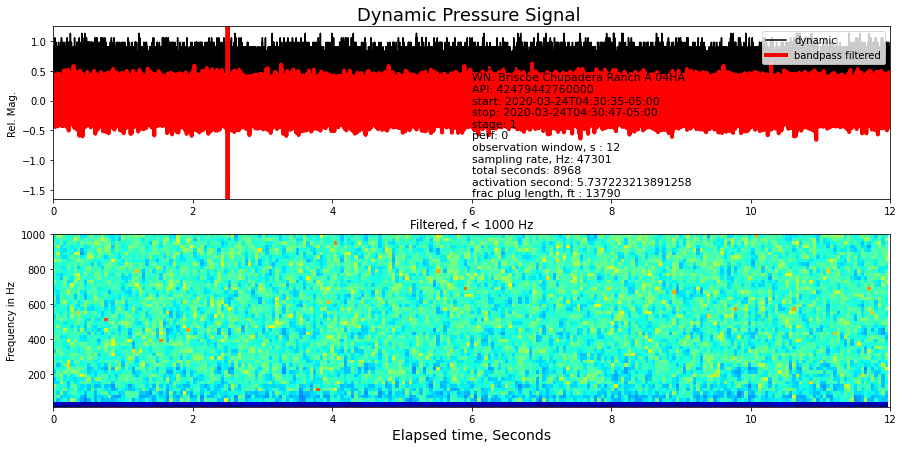

Files downloaded in  1.4867253303527832
stamped time: 12
total time observed: 12.000046095694662


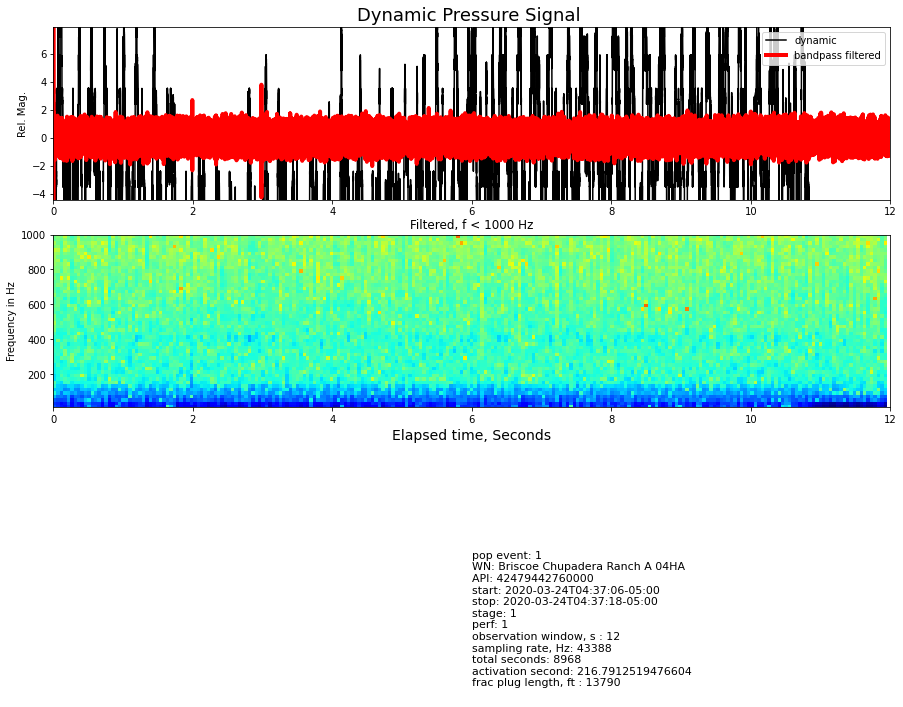

Files downloaded in  2.026719093322754
stamped time: 12
total time observed: 12.000233868395876


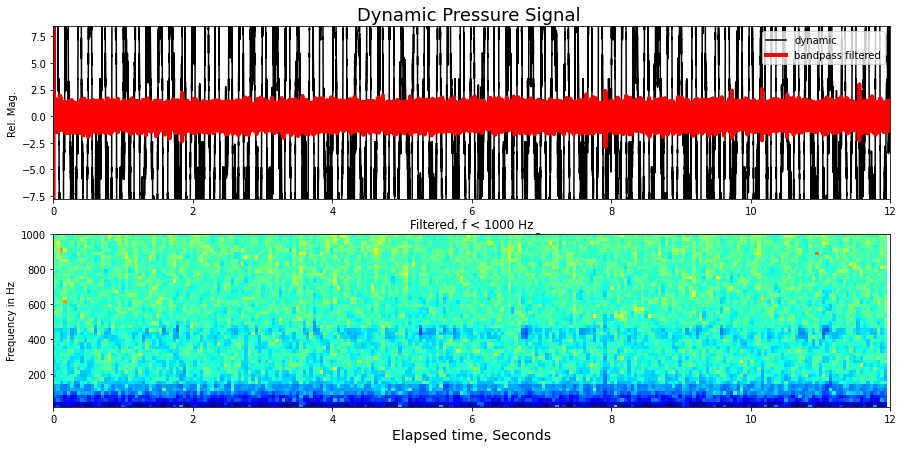

Files downloaded in  1.5065219402313232
stamped time: 12
total time observed: 12.000106303816308


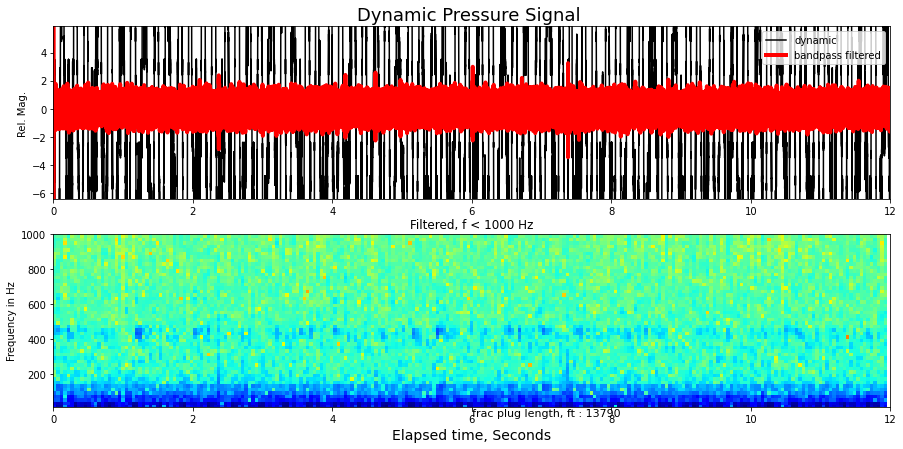

Files downloaded in  1.4038114547729492
stamped time: 12
total time observed: 12.000169305002963


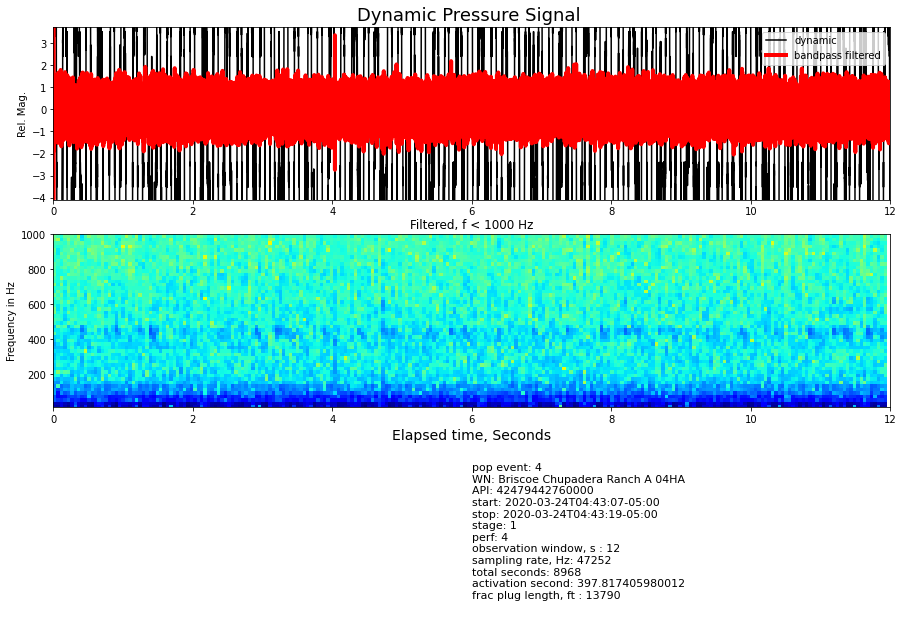

Files downloaded in  1.3854224681854248
stamped time: 12
total time observed: 12.000191346869352


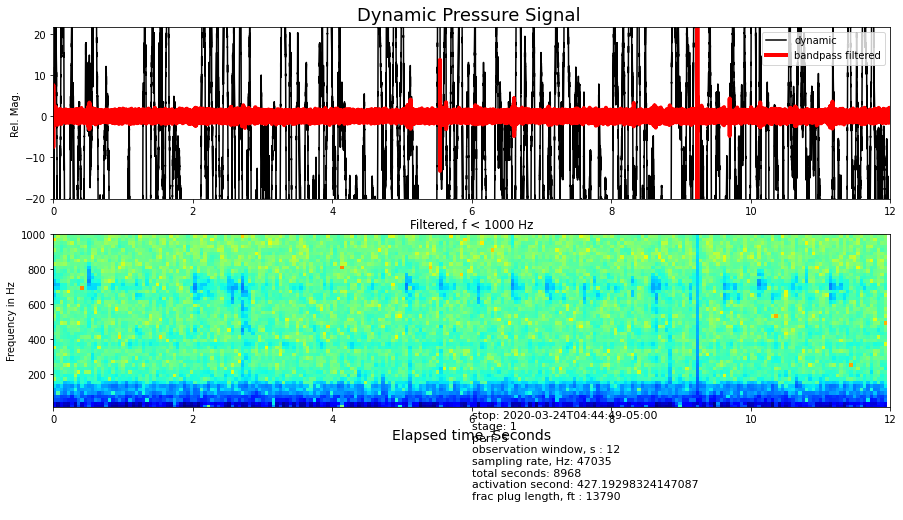

Files downloaded in  1.3408904075622559
stamped time: 12
total time observed: 12.000105869399508


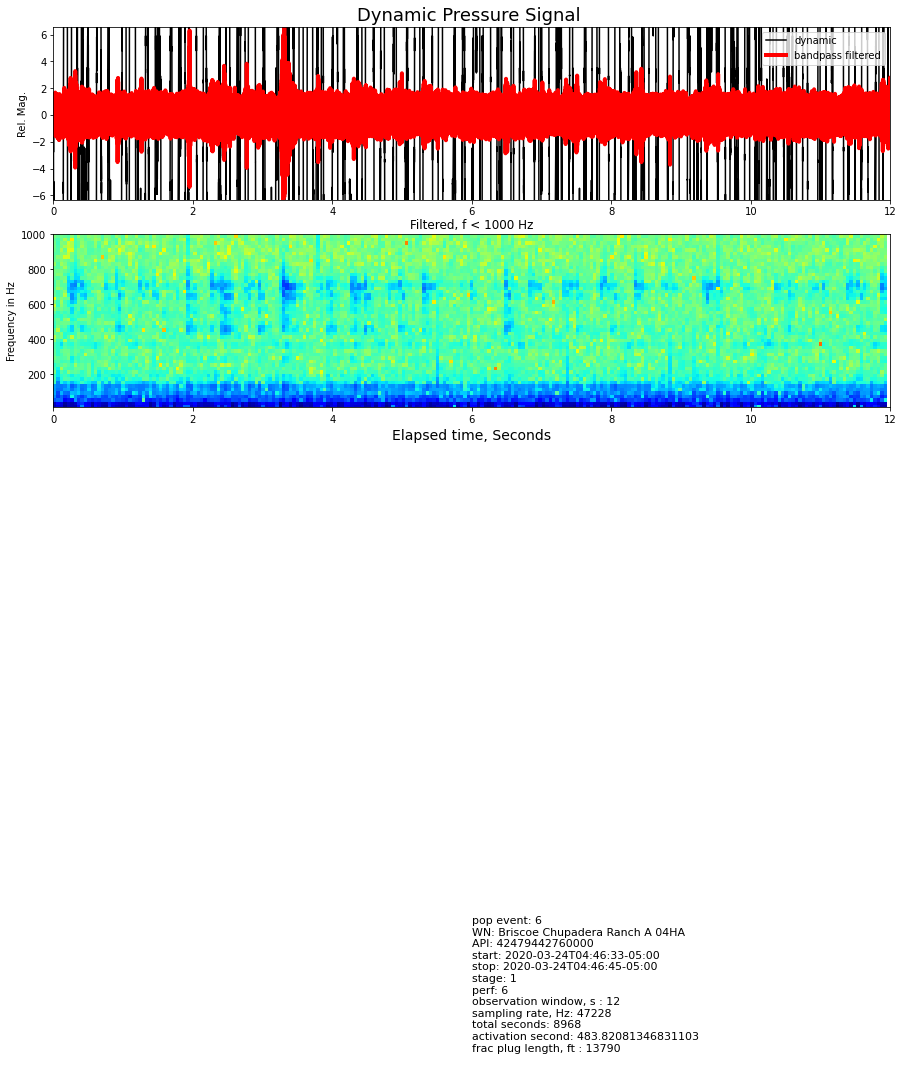

Files downloaded in  1.3276879787445068
stamped time: 12
total time observed: 12.000050286633813


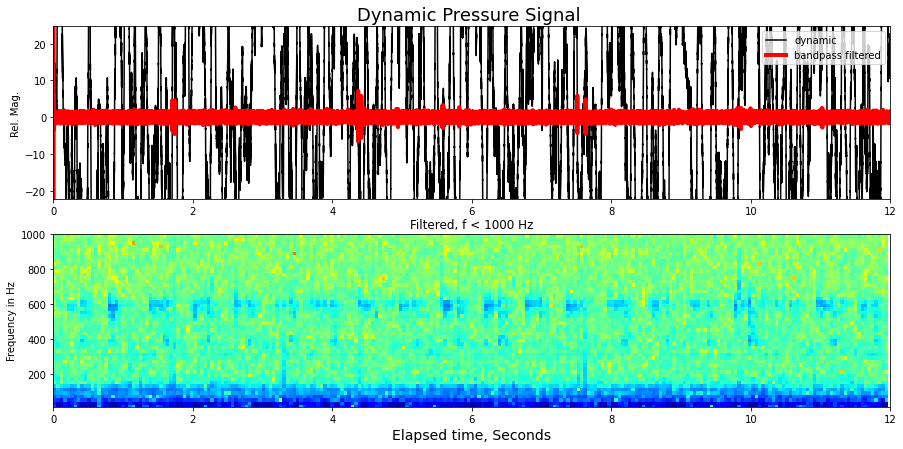

Files downloaded in  1.359496831893921
stamped time: 12
total time observed: 12.000115260488705


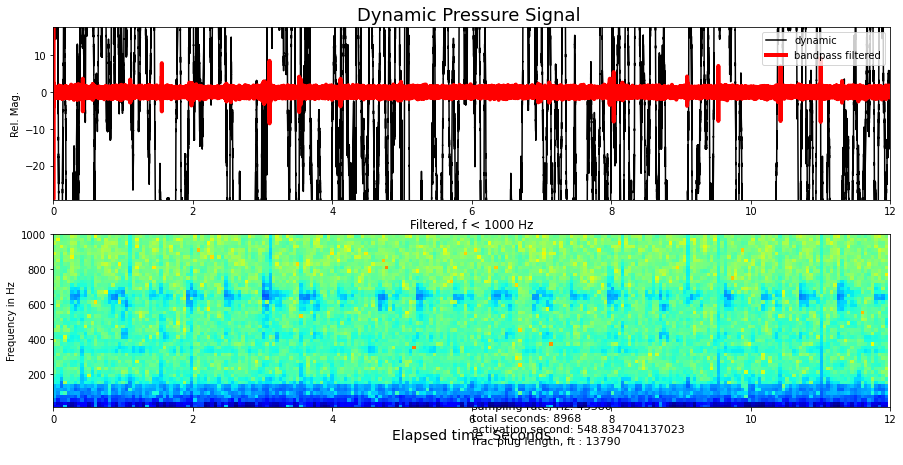

Files downloaded in  1.345677375793457
stamped time: 12
total time observed: 12.000115013916684


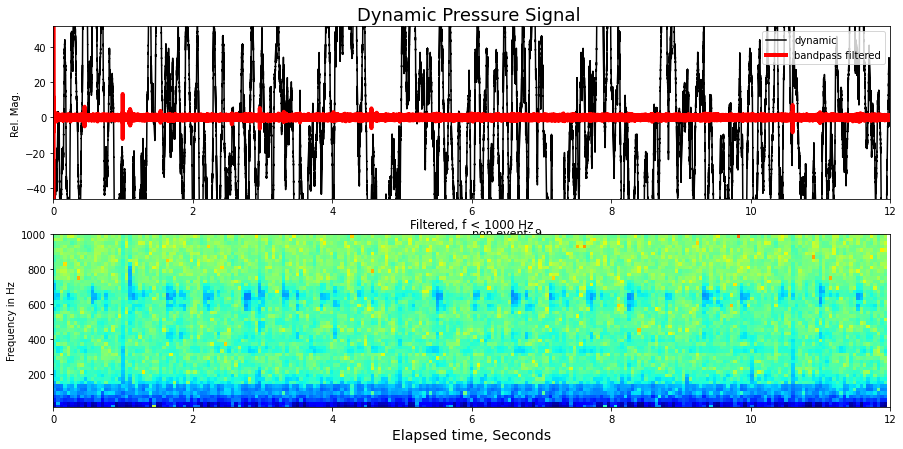

Files downloaded in  2.1618101596832275
stamped time: 12
total time observed: 12.000191099031765


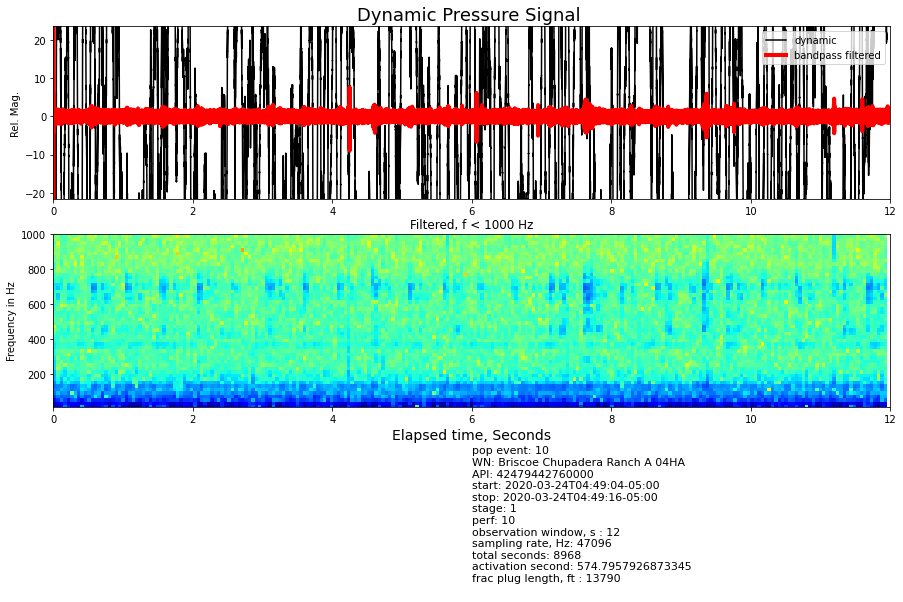

Files downloaded in  1.375101089477539
stamped time: 12
total time observed: 12.0


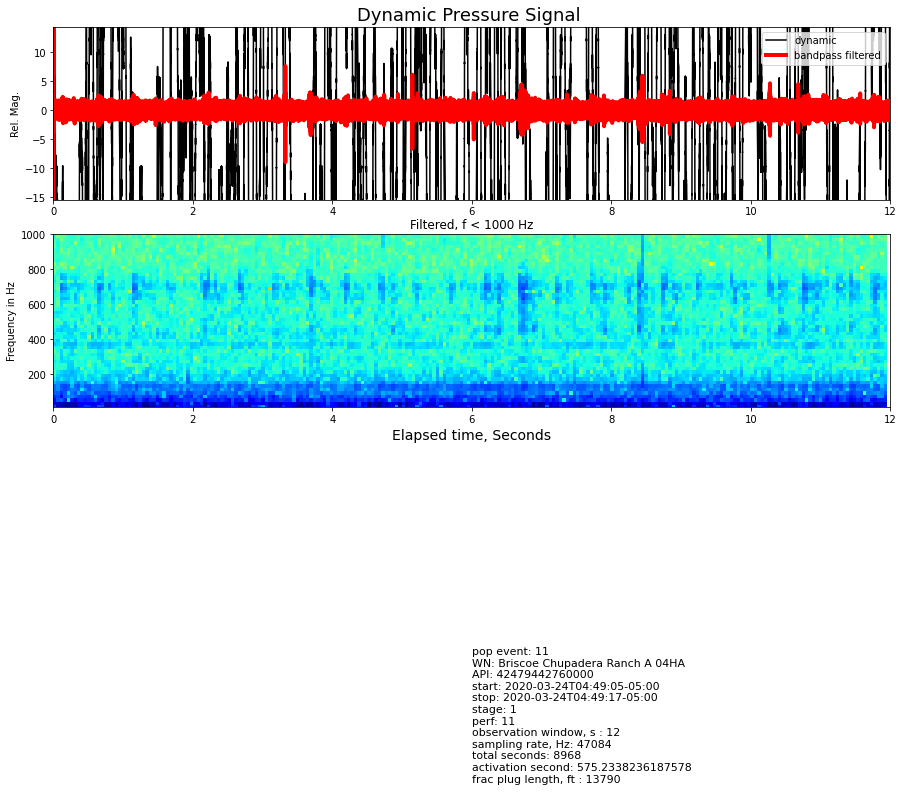

Files downloaded in  1.3864855766296387
stamped time: 12
total time observed: 12.0


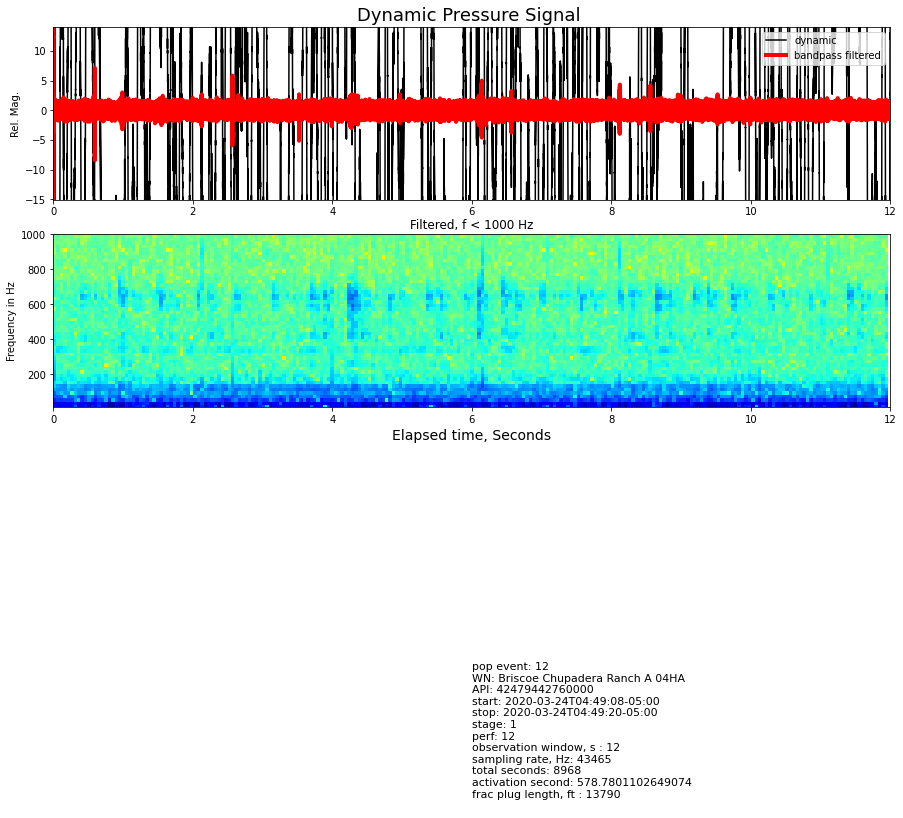

Files downloaded in  1.4398159980773926
stamped time: 12
total time observed: 12.000127751990801


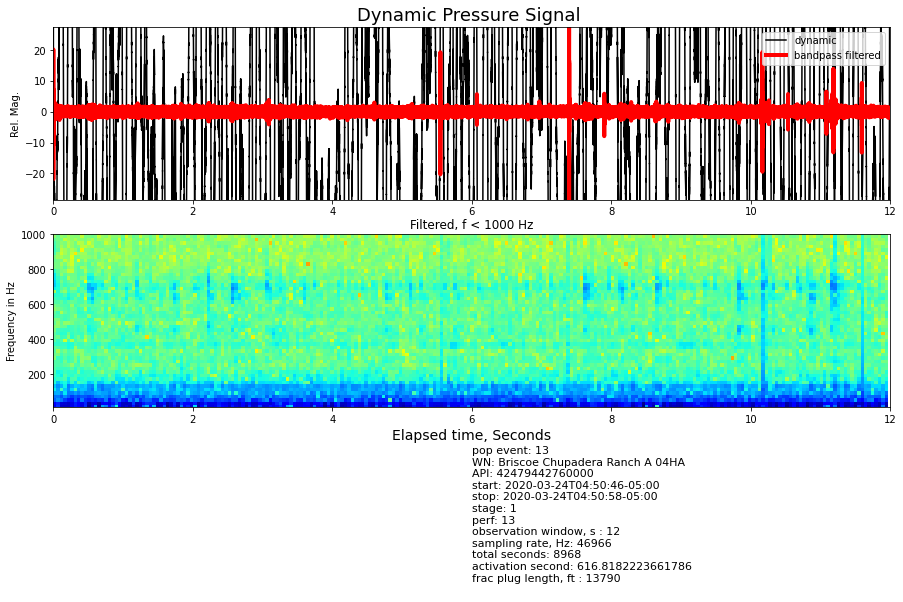

Files downloaded in  1.4186415672302246
stamped time: 12
total time observed: 12.000127626988855


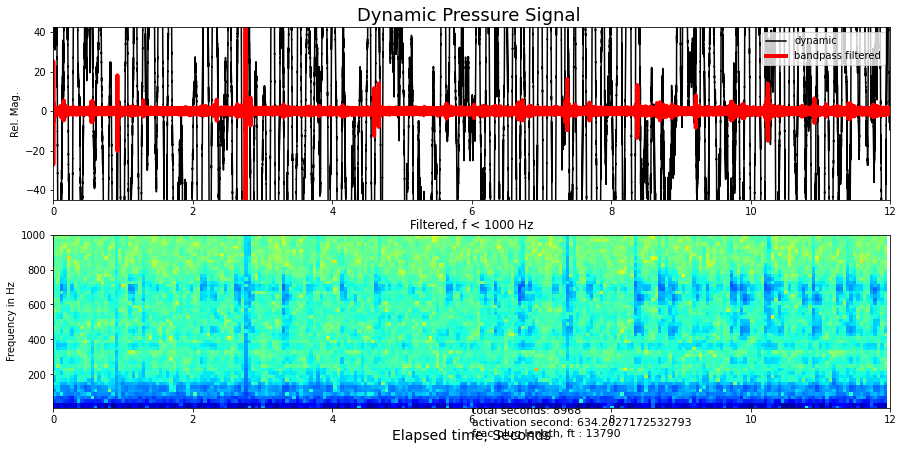

Files downloaded in  1.5093598365783691
stamped time: 12
total time observed: 12.000045872611757


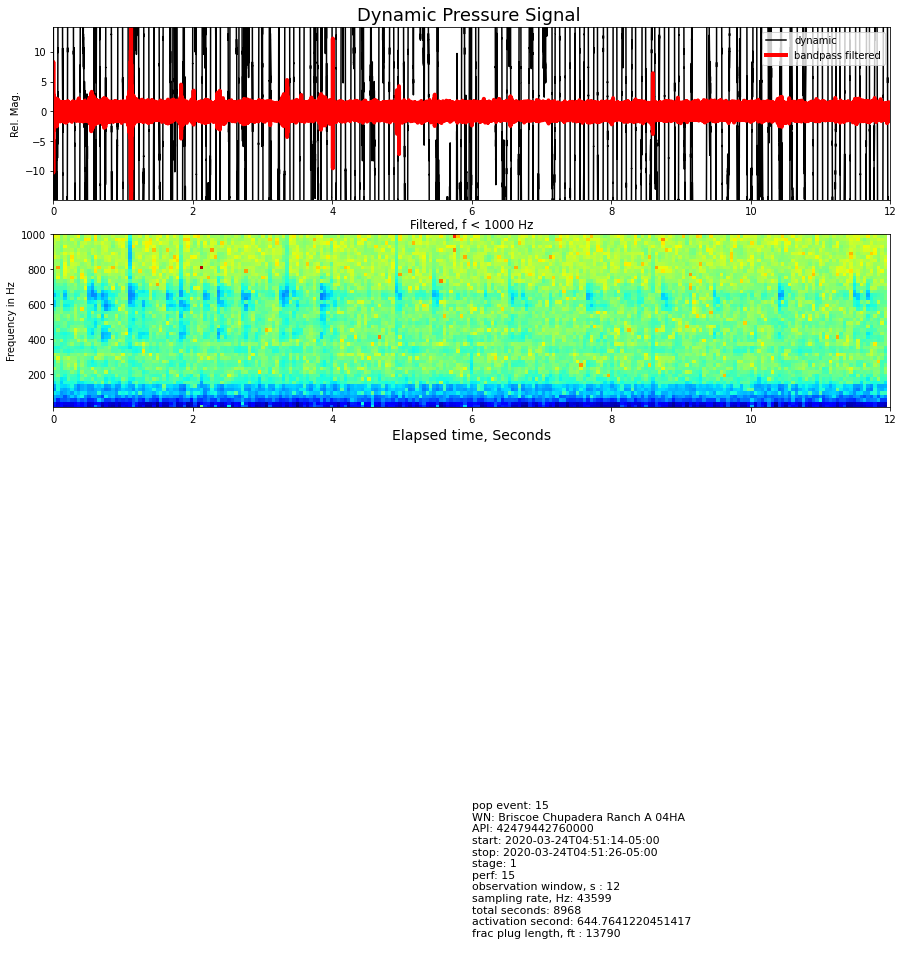

Files downloaded in  1.45607590675354
stamped time: 12
total time observed: 12.000148841165213


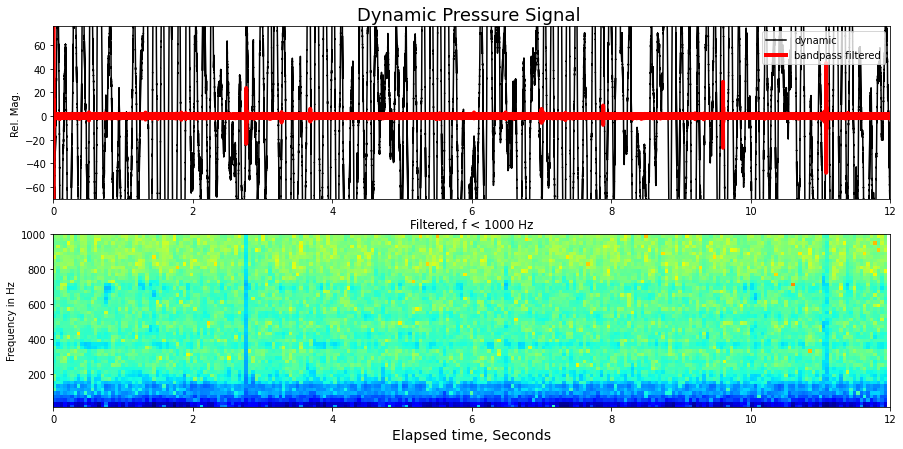

Files downloaded in  1.398298740386963
stamped time: 12
total time observed: 12.000161465181186


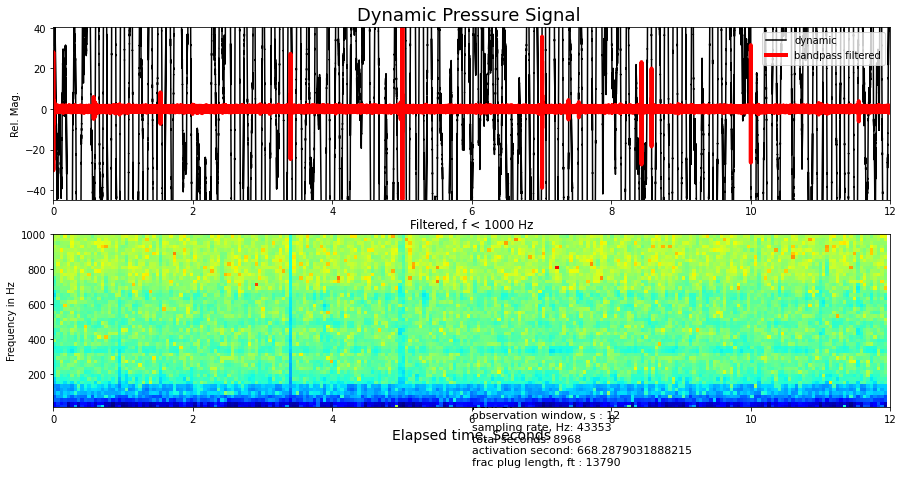

Files downloaded in  1.4807393550872803
stamped time: 12
total time observed: 12.000191050352381


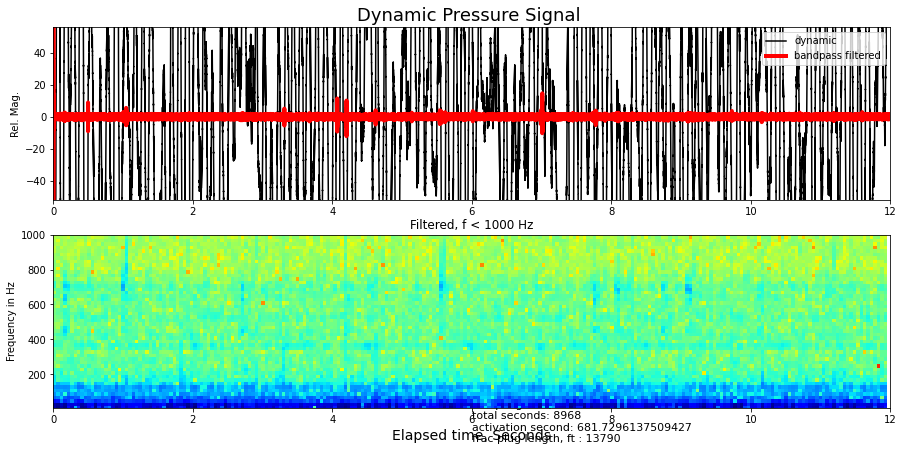

Files downloaded in  1.4254834651947021
stamped time: 12
total time observed: 12.00021183299087


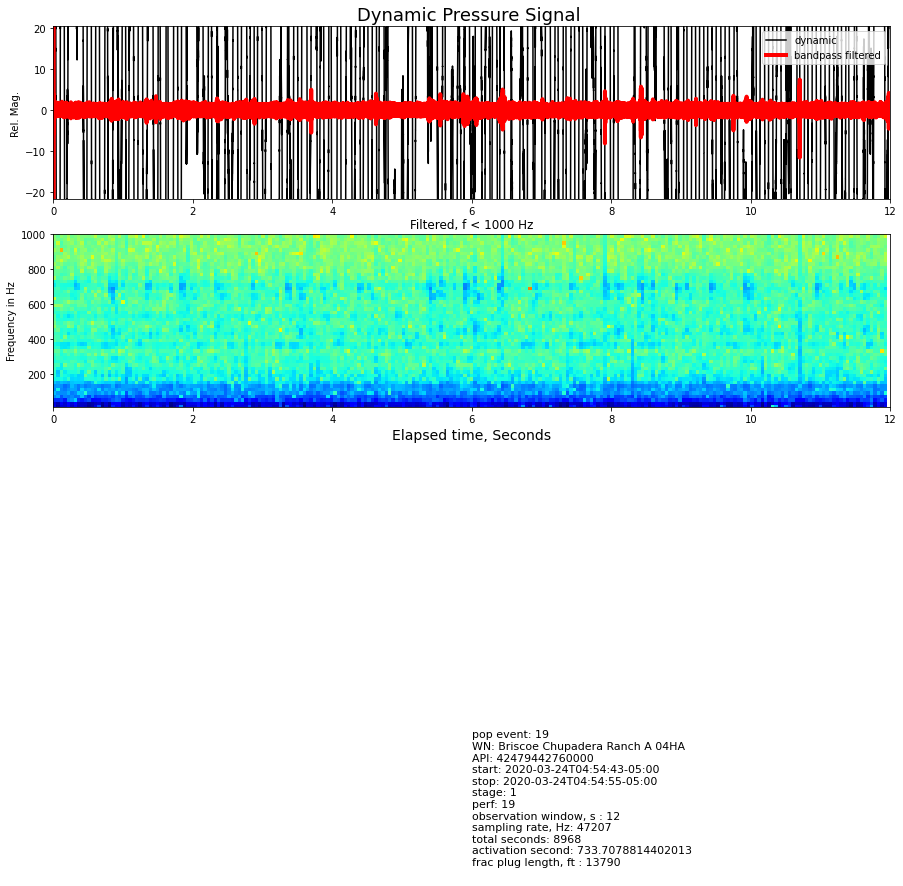

Files downloaded in  1.448033094406128
stamped time: 12
total time observed: 12.000169779286926


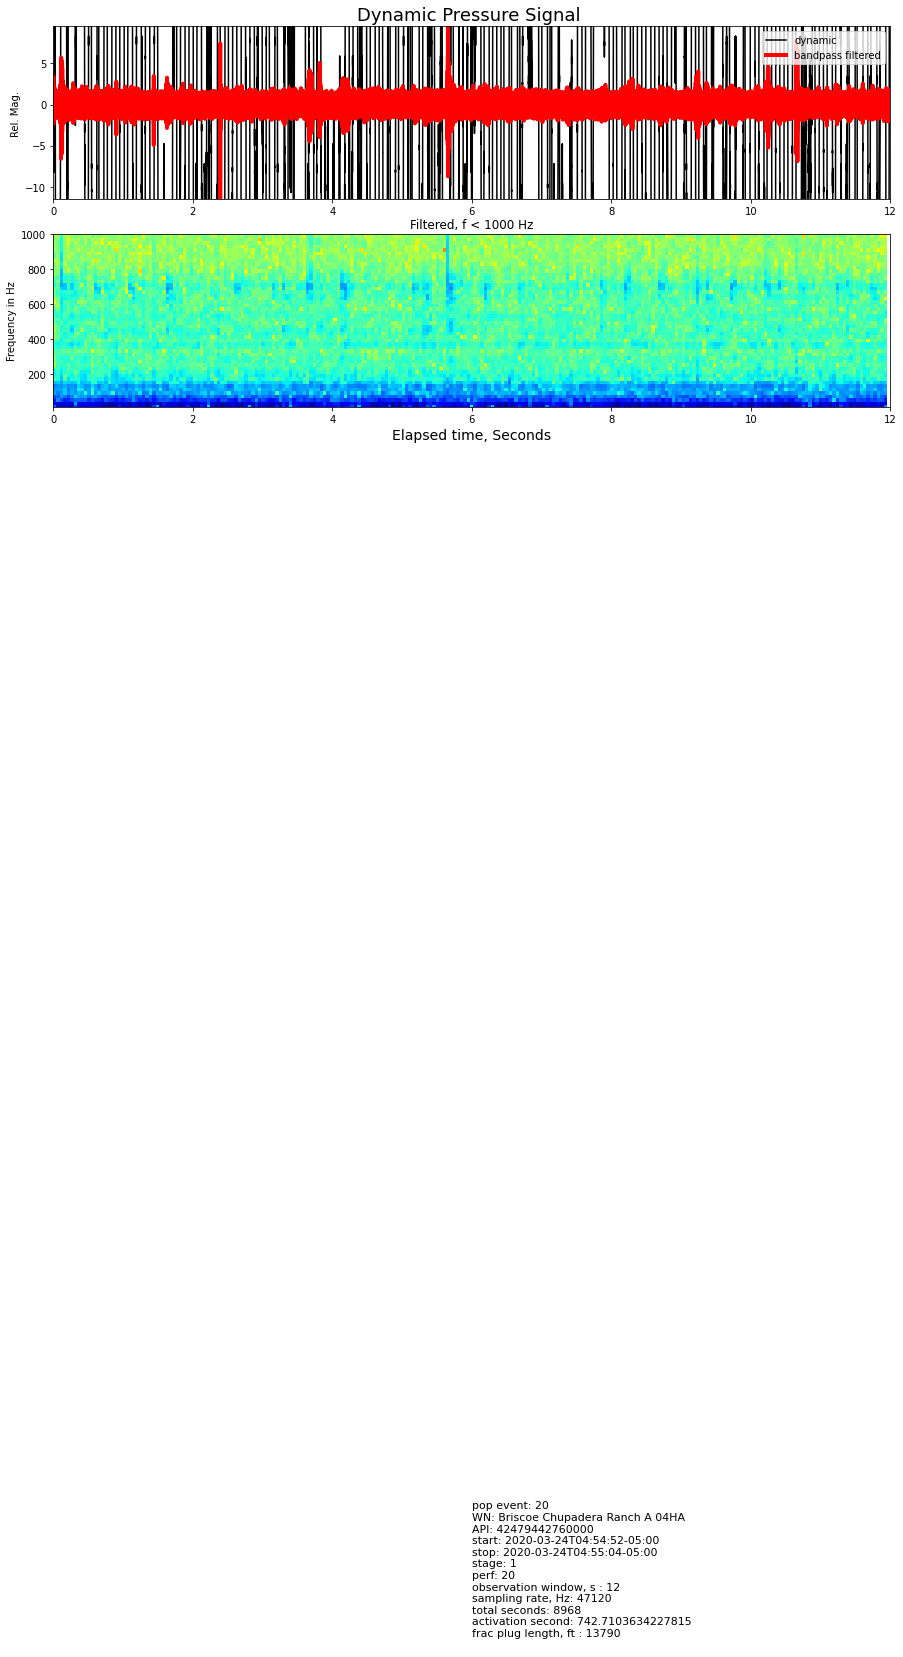

Files downloaded in  2.380950927734375
stamped time: 12
total time observed: 12.000063667232597


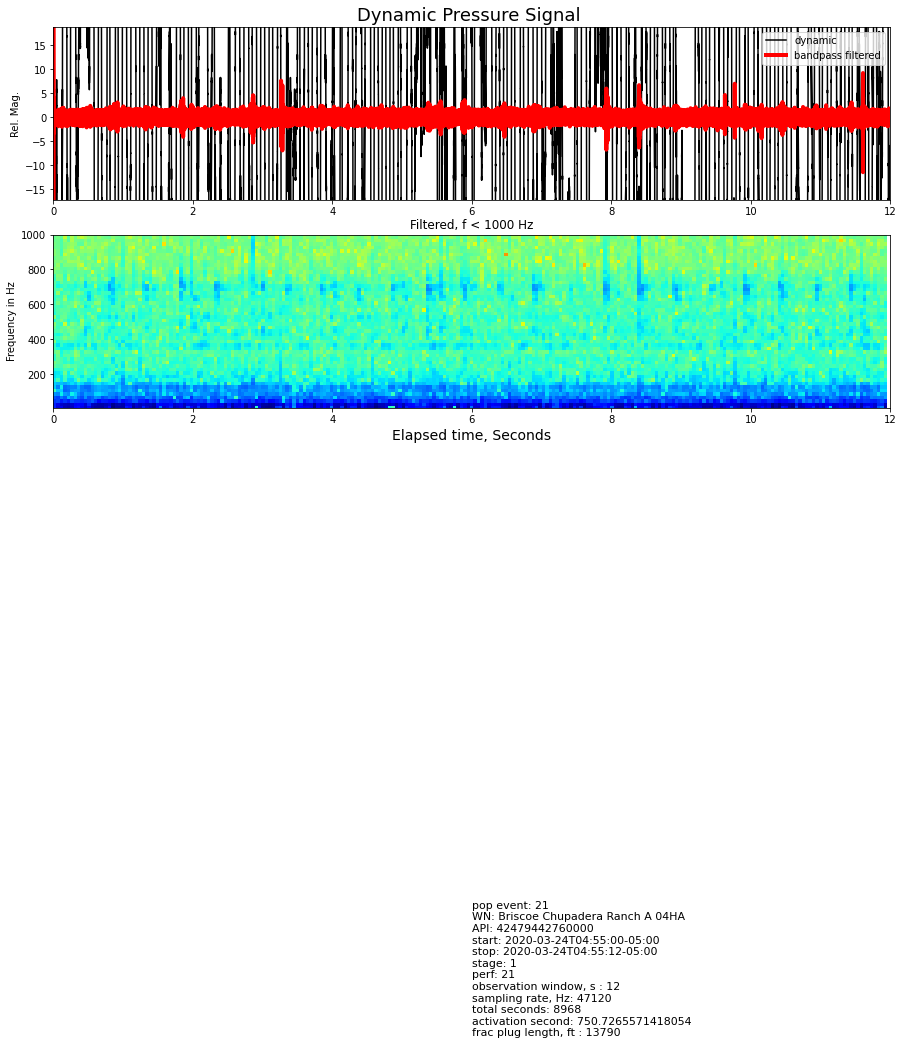

Files downloaded in  2.501789093017578
stamped time: 12
total time observed: 12.000085082849425


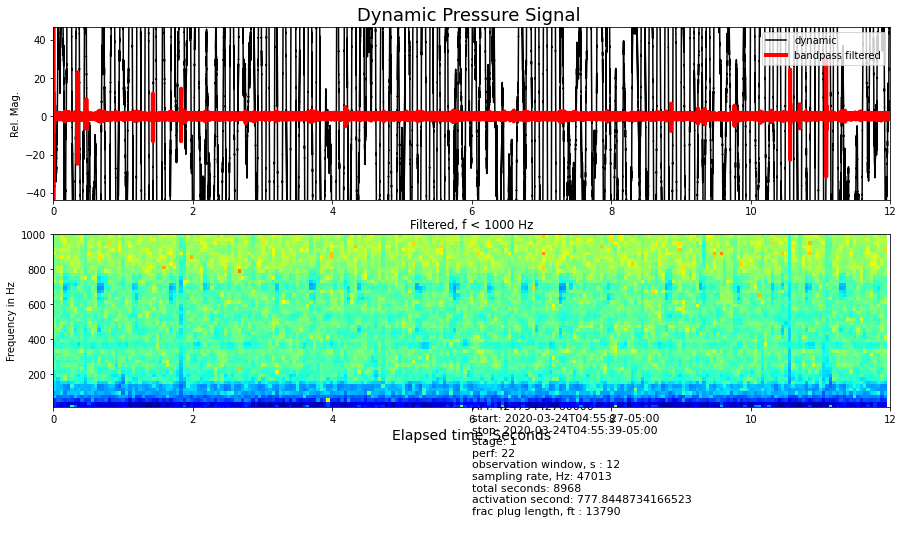

Files downloaded in  1.5083391666412354
stamped time: 12
total time observed: 12.00002132059783


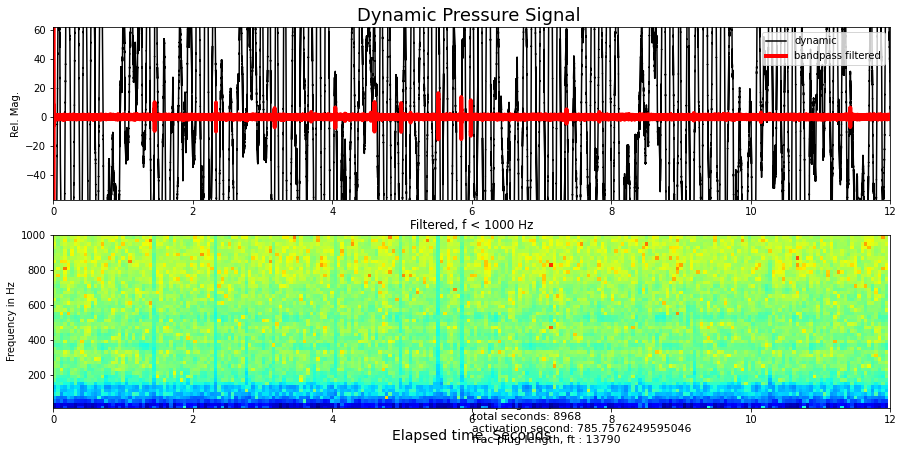

Files downloaded in  1.5298311710357666
stamped time: 12
total time observed: 12.0


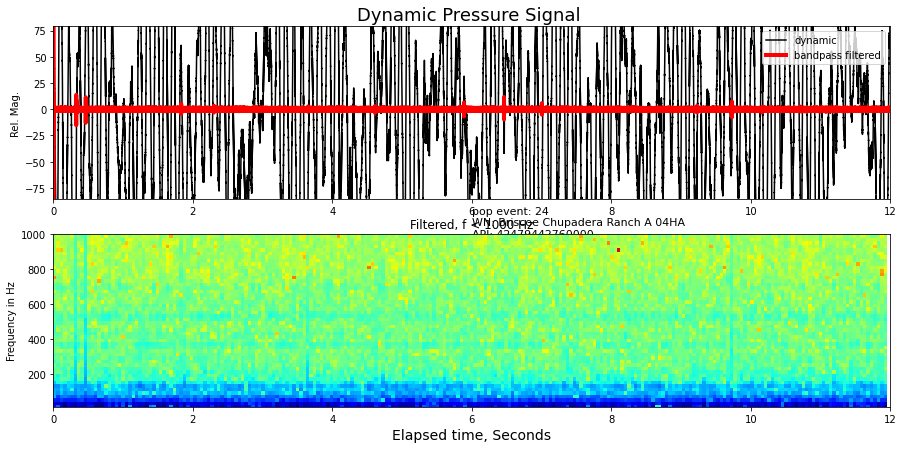

Files downloaded in  1.5590693950653076
stamped time: 12
total time observed: 12.000106292517007


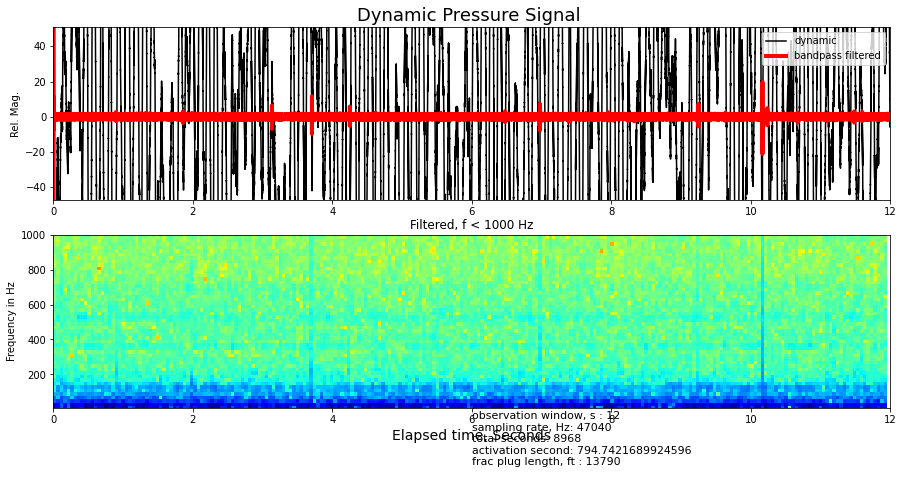

Files downloaded in  1.5536015033721924
stamped time: 12
total time observed: 12.000212775011702


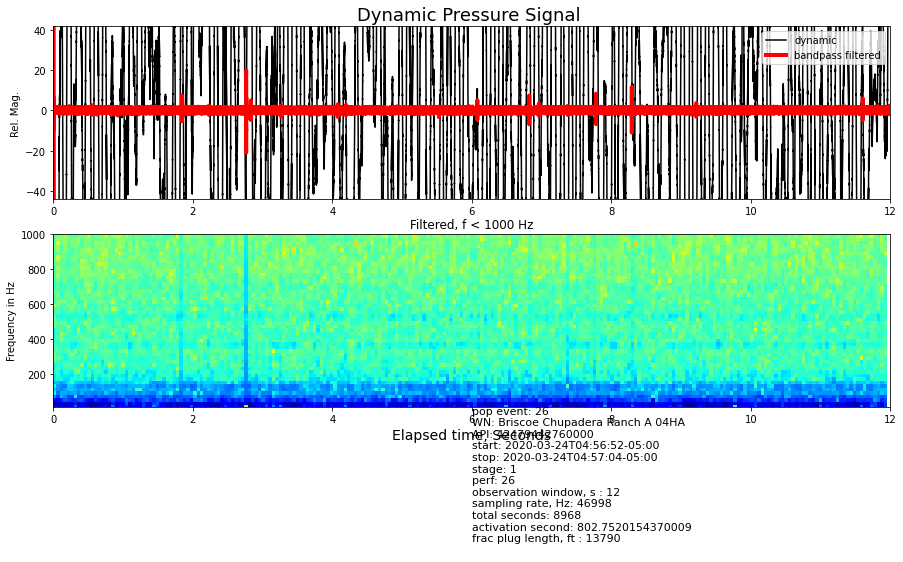

Files downloaded in  1.5240552425384521
stamped time: 12
total time observed: 12.000042532377773


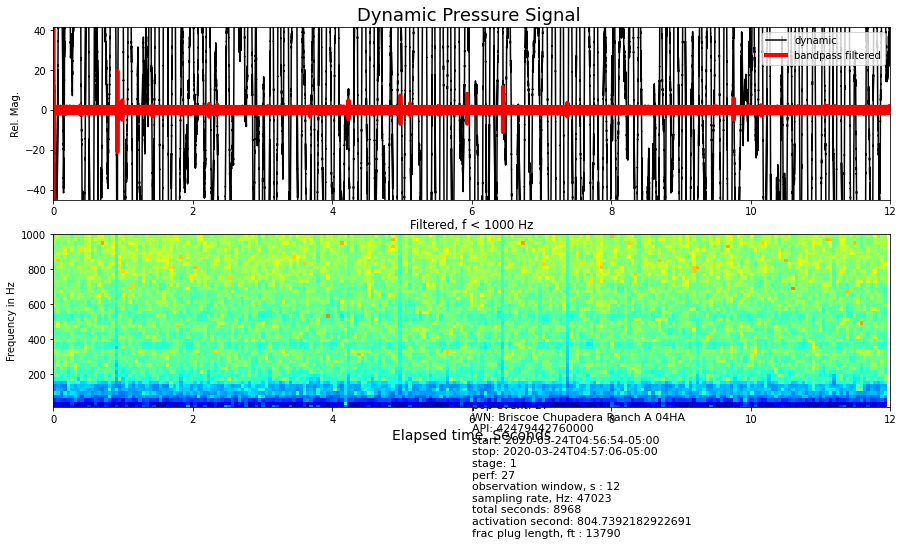

Files downloaded in  1.5696675777435303
stamped time: 12
total time observed: 12.0


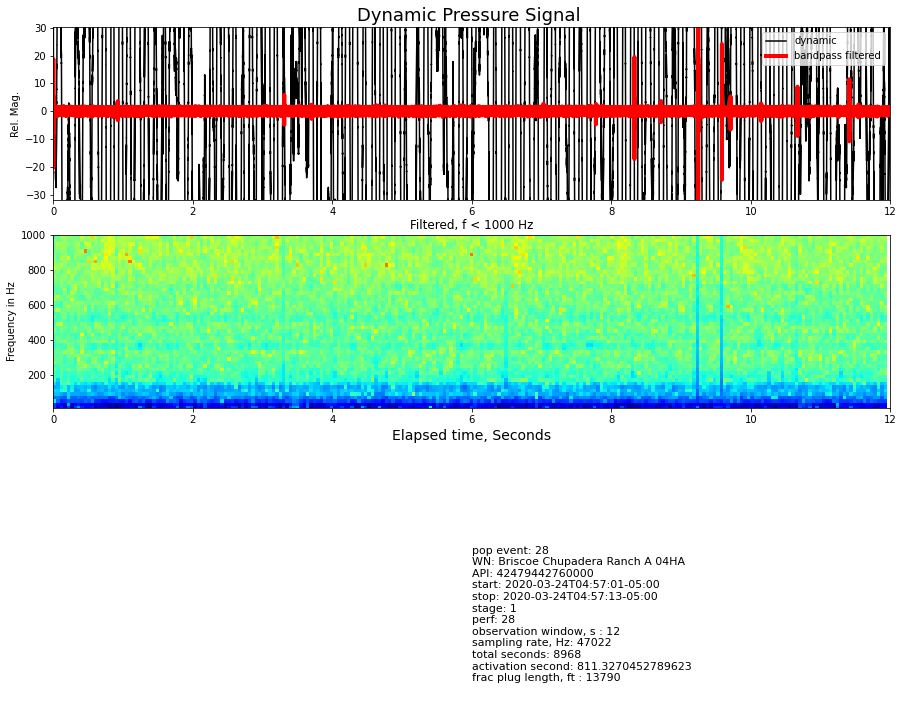

Files downloaded in  1.6742527484893799
stamped time: 12
total time observed: 12.0


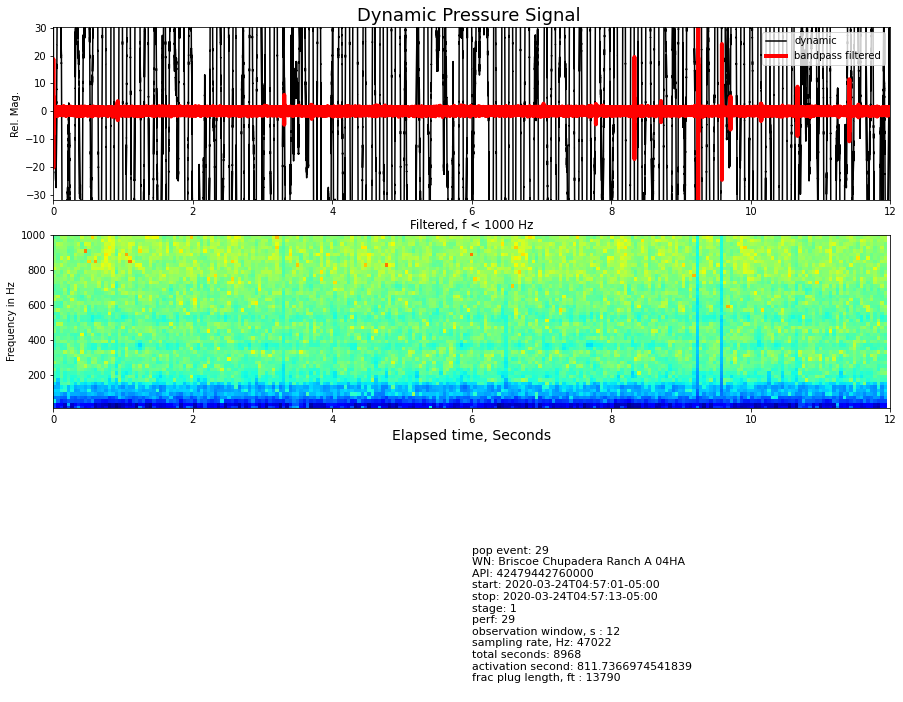

In [5]:
#
#  Cycle through all Fracs individually
#

import matplotlib.pyplot as plt
import pylab
import scipy.signal as signal

ignoreEvents = [] # populate this list if there are misclassified events you want to remove.

staticID = '7640ae5c-6f31-4fd0-83d8-b85936670a9c'

fracPopsData = np.load('ImpulseInvestigations/fracture_dataset.npy', allow_pickle=True)

# print length of data set, ~75k

print('size of frac data set: ' + str(len(fracPopsData)))

# uncomment below to cycle through all 75k events!

#for i in range(len(fracPopsData)):

# look at first 30 pops instead:

for i in range(30):
    
    if any(i == j for j in ignoreEvents) == False: # move past any index elements in the ignoreEvents list
        
        #[WN,Api,window_start_str,window_stop_str,stage,idx,obsWindow,sampling_rate,seconds,activation_second,fracPlugDepth])
        
        WN = fracPopsData[i][0]
        api = fracPopsData[i][1]
        start = fracPopsData[i][2]
        stop = fracPopsData[i][3]
        stage = fracPopsData[i][4]
        perf = i
        obsWindow = fracPopsData[i][6]
        sampling_rate = fracPopsData[i][7]
        totalSecs = fracPopsData[i][8]
        activationSec = fracPopsData[i][9]
        fracPlugLength = fracPopsData[i][10]
        dynamicID = fracPopsData[i][11]
        
        # make vals:
        #vals = fracPopsData[i][11]
        
        
        vals,t_d,x_s,t_s,sampling_rate,seconds = makeData(dynamicID, staticID, start, stop)
        
        outText = 'pop event: ' + str(i) + '\n'
        outText += 'WN: ' + WN + '\n'
        outText += 'API: ' + api + '\n'
        outText += 'start: ' + start + '\n'
        outText += 'stop: ' + stop + '\n'
        outText += 'stage: ' + str(stage) + '\n'
        outText += 'perf: ' + str(perf) + '\n'
        outText += 'observation window, s : ' + str(obsWindow) + '\n'
        outText += 'sampling rate, Hz: ' + str(sampling_rate) + '\n'
        outText += 'total seconds: ' + str(totalSecs) + '\n'
        outText += 'activation second: ' + str(activationSec) + '\n'
        outText += 'frac plug length, ft : ' + str(fracPlugLength) + '\n'

        print('stamped time: ' + str(obsWindow))

        measuredTime = len(vals)/sampling_rate
        
        print('total time observed: ' + str(measuredTime))

        timeVals = np.linspace(0,measuredTime,len(vals))

        # use the bandpass filter to see the BASIS events

        bp_data = butter_bandpass_filter(vals,30,900,sampling_rate,order=9)

        # or remove low freq data to see pops

        sos_pops = signal.butter(10,30,btype='highpass',fs=sampling_rate,output='sos')

        # Filtered_xd is the dynamic pressure response, with f < 800 Hz contributions removed. 

        filtered_xd = signal.sosfilt(sos_pops,vals)
        dyn_fitrd_bp = butter_bandpass_filter(vals,800,14000,sampling_rate,order=9) 


        # spectro details

        #
        # Optimal vals so far
        #
        #TIME_SAMPLE_WINDOW = .5
        #OVERLAP_FACTOR = 500


        # try to find better ones

        TIME_SAMPLE_WINDOW = .05
        OVERLAP_FACTOR = 50

        NFFT = int(sampling_rate*TIME_SAMPLE_WINDOW)  # 5ms window
        noverlap = int(sampling_rate*(TIME_SAMPLE_WINDOW / OVERLAP_FACTOR))

        CUTOFF_FREQ = 10
        # sepctro figure stuff

        F_MIN = 10
        F_MAX = 1000

        COLORMAP = 'jet_r'

        # plot dims in inches

        fig_x = 15
        fig_y = 7

        # subplots stuff

        fig, axs = plt.subplots(2,1,figsize=(fig_x,fig_y))
        #fig.suptitle(outText)

        # 1st plot, dynamic signal 

        axs[0].set_title('Dynamic Pressure Signal ', fontsize = 18, color='black')
        axs[0].plot(timeVals, vals, color='black', label = 'dynamic',zorder=1)
        axs[0].plot(timeVals, dyn_fitrd_bp, color='red', label = 'bandpass filtered',zorder=1, linewidth=4)
        axs[0].axis([0 ,measuredTime, np.nanmin(vals), np.nanmax(vals)])
        axs[0].legend(loc='upper right')
        axs[0].text(int(measuredTime/2),0.6*min(vals),outText,fontsize=11,verticalalignment='center')
        #axs[0].set_xlabel('Elapsed time, Seconds')
        axs[0].set_ylabel('Rel. Mag.')
        axs[0].axis([0,measuredTime,np.nanmin(dyn_fitrd_bp),np.nanmax(dyn_fitrd_bp)])


        # Spectro, filtered
        axs[1].specgram(vals, NFFT=NFFT, Fs=sampling_rate, noverlap=noverlap, cmap=pylab.get_cmap(COLORMAP))
        #axs[1].specgram(vals, NFFT=None, Fs=sampling_rate, noverlap=128, cmap=pylab.get_cmap(COLORMAP))
        axs[1].set_title('Filtered, f < 1000 Hz')
        axs[1].set_xlabel('Elapsed time, Seconds',fontsize=14)
        axs[1].set_ylabel('Frequency in Hz')
        axs[1].axis([0,measuredTime,F_MIN,F_MAX])
                                
        plt.show()